# Chapitre 3. Classification

## MNIST

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1, data_home="C:\\Users\\tchak\\scikit_learn_data")
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
print(X.shape, y.shape)

(70000, 784) (70000,)


(-0.5, 27.5, 27.5, -0.5)

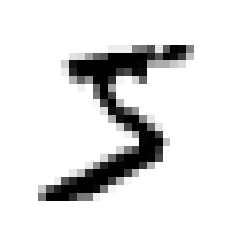

In [3]:
import numpy as np
import matplotlib.pyplot as plt
some_digit = np.array(X[:1])
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")

In [4]:
y[0]

'5'

In [5]:
y = y.astype(np.uint8)

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Entrainement d'un classificateur binaire

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [8]:
# Classificateur de descente de gradient stochastique (Stochastic Gradient Descent - SGD)
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict(X[:1]) # True!

array([ True])

## Mesures de performance

### Mesurer l'exactitude à l'aide de la validation croisée

In [9]:
# Implementation d'une validation croisée (meilleur contrôle du processus)
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# Echantillonage stratifié pour produire des blocs contenant un ratio représentatif de chaque classe

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.loc[train_index]
    y_train_folds = y_train_5.loc[train_index]
    X_test_fold = X_train.loc[test_index]
    y_test_fold = y_train_5.loc[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
# Résultats plutôt satisfaisants

0.9669
0.91625
0.96785


In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
# > 95%, stupéfiant, mais pas assez, on verra pourquoi

array([0.95035, 0.96035, 0.9604 ])

In [11]:
# Classificateur dénué de toute intelligence
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool) # Retourne juste une matrice unicolonne nulle

In [12]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
# > 90% avec ce classificateur -> en effet les 5 ne représentent que 10% des images
# Décider à chaque fois qu'une image n'est pas 5 -> avoir raison dans 90% des cas
# L'exactitude n'est pas en général une mesure de performance surtout en cas d'asymétrie des données

array([0.91125, 0.90855, 0.90915])

### Matrice de confusion

In [13]:
# Capter les observations rangées dans la mauvaise classe
# Ne pouvant pas utiliser le jeu test -> cross_val_predict

from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
# Prédiction dite saine (par un modèle qui n'a jamais rencontré les données) pour chaque bloc de test

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)
# En ligne la classe réelle, en colonne la classe prédite
# TrueNegative     FalseNegative 
# FalsePositive    TruePositive

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

### Précision et rappel

In [14]:
from sklearn.metrics import precision_score, recall_score
print("Precision:", precision_score(y_train_5, y_train_pred),
      "\nRappel:", recall_score(y_train_5, y_train_pred))

# Précision -> exactitude des prédictions positives - TP / (TP + FP)
# Lorsqu'il declare qu'une image est 5, il n'a raison que 83.71% du temps

# Rappel (sensibilité, True Positive Rate) -> Nombre d'observations positives detectées TP / (TP + FN)
# Il ne detecte que 65.11% des 5

Precision: 0.8370879772350012 
Rappel: 0.6511713705958311


In [15]:
# Score F1 -> moyenne harmonique de la précision et du rappel, donne plus de poid aux faibles valeurs
# Bon score F1 si précision et rappel élevés 
# F1 = 2 / [(1/precision) + (1/rappel)]
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)
# Favorise les classificateurs ayant une précision et un rappel similaires

0.7325171197343846

### Compromis précision/rappel

In [16]:
# Augmentation de la précision -> baisse du rappel
# Augmentation du rappel -> baisse de la précision

# Accès manuel au score pour personnaliser le seuil de décision
y_scores = sgd_clf.decision_function(X[:1])
y_scores

array([2164.22030239])

In [17]:
threshold = 8000 # 0 par defaut
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [18]:
# Comment décider du seuil à utiliser?
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

plt.style.use("Solarize_Light2")
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Rappel")

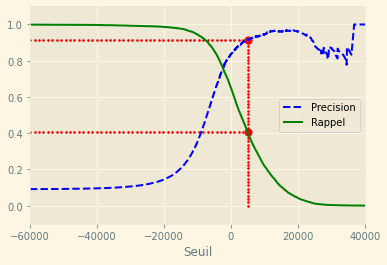

In [19]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

seuil = 5000
prec_seuil = precisions[np.argmin(thresholds <= seuil)]
rapp_seuil = recalls[np.argmin(thresholds <= seuil)]

plt.scatter(seuil, prec_seuil, c="r", marker="o", s=50)
plt.scatter(seuil, rapp_seuil, c="r", marker="o", s=50)
plt.scatter(np.linspace(seuil, seuil), np.linspace(0, max([prec_seuil, rapp_seuil])),
            marker=".", s=10, c="r")
plt.scatter(np.linspace(-60000, seuil), np.linspace(prec_seuil, prec_seuil), marker=".", s=10, c="r")
plt.scatter(np.linspace(-60000, seuil), np.linspace(rapp_seuil, rapp_seuil), marker=".", s=10, c="r")

plt.xlim(-60000, 40000)
plt.ylim(-.1, 1.1)
plt.xlabel("Seuil")
plt.legend(loc="best")

(0.0, 1.0)

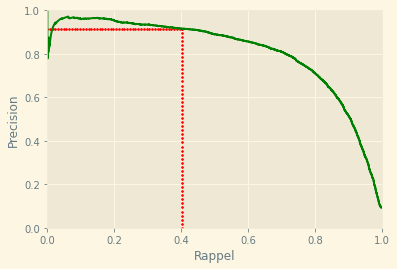

In [20]:
plt.plot(recalls, precisions, c="green")
plt.scatter(np.linspace(0, rapp_seuil), np.linspace(prec_seuil, prec_seuil),  marker=".", s=10, c="r")
plt.scatter(np.linspace(rapp_seuil, rapp_seuil), np.linspace(0, prec_seuil),  marker=".", s=10, c="r")
plt.xlabel("Rappel")
plt.ylabel("Precision")
plt.xlim(0, 1)
plt.ylim(0, 1)

In [21]:
# Si l'on souhaite avoir une pracision de 90%
threshold_90_precision = thresholds[np.argmax(precisions >= .90)] # ~ 3370
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [22]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [23]:
recall_score(y_train_5, y_train_pred_90) # Rappel trop bas (dapendant du projet!)

0.4799852425751706

### La courbe ROC

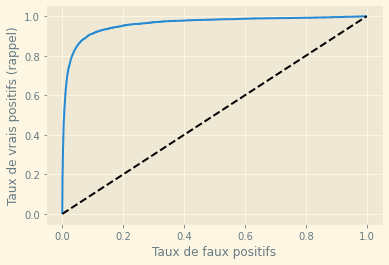

In [24]:
# Courbe d'efficacita du racepteur (Receiver Operating Characteristic)
# Croise le taux de vrais positifs (rappel) avec le taux de faux positifs
# Taux de faux positifs -> pourcentage d'observations nagatives incorrectement classaes comme positives
# FPR = 1 - TNR = 1 - specificite
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--") # diagonale pointilae
    plt.xlabel("Taux de faux positifs")
    plt.ylabel("Taux de vrais positifs (rappel)")
    
plot_roc_curve(fpr, tpr)

# Similaire à la courbe pracision/rappel (courbe PR) à préférer lorsque la classe positive est rare ou
# si l'on attache davantage d'importance aux faux positifs qu'aux faux negatifs

In [25]:
from sklearn.metrics import roc_auc_score # Area Under the Curve
roc_auc_score(y_train_5, y_scores)
# Classificateur purement aléatoire -> auc = 1/2
# Classificateur parfait -> auc = 1

0.9604938554008616

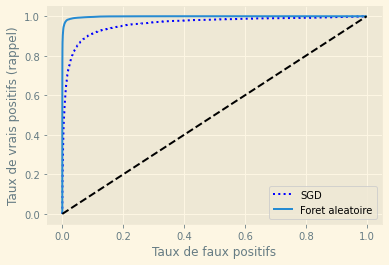

In [26]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method="predict_proba")
y_scores_forest = y_probas_forest[:, 1] # score = probas de la classe positive
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Foret aleatoire")
plt.legend(loc=0)

In [27]:
y_forest_predict = y_scores_forest > .5
print("ROC AUC score:", roc_auc_score(y_train_5, y_scores_forest),
      "\nPrecision:", precision_score(y_train_5, y_forest_predict),
      "\nRappel:", recall_score(y_train_5, y_forest_predict))

ROC AUC score: 0.9983436731328145 
Precision: 0.9905083315756169 
Rappel: 0.8662608374838591


## Classification multi-classes

In [ ]:
# La desente de gradient stochastique (SGD), la classification par forets aleatoires (RandomForest) et
# la classification naive bayesienne sont capables de gerer des classes multiples

# La regression logistique et les machines a vecteurs de support (SVM) sont strictement binaires

In [ ]:
# Pour classer les chiffres de 0 a 9, on peut entrainer 10 classificateurs binaires (1 par chiffre) et
# predire la label d'une image en comparant le score pour celle-ci de chaun de ces classificateurs
# Strategie un contre le reste (one-vs-the-rest / OvR) ou un contre tous (one-vs-all / OvA)

# On peut egalement entrainer un classificateur binaire pour chaque paire de chiffres -> Strategie un
# contre un (one-vs-one / OvO) -> C(2, n) classificateurs ie. 45 dans notre cas. L'on choisit dans ce
# cas la classe ayant remporte le plus de duels (3 vs 1, 2, 4, 6, 7, 9 -> 3, 3 vs 5, 8 -> 5, 8, donc 3)
# Avantage -> chaque classificateur n'a besoin d'etre entraine que sur la partie du jeu d'entrainement
# correspondant aux deux classes qu'il doit distinguer

In [ ]:
# Les SVM par exemple ne s'adptent pas bien aux jeux d'entrainement de grande taille -> OvO preferables
# Mais en general, pour les classificateus binaires on preferera une strategie OvR

In [28]:
# Classificateur binaire pour multi-classes, OvR ou OvO selon les cas (par defaut)
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, not y_train_5
svm_clf.predict(some_digit) # Bonne prediction

C:\Users\tchak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [31]:
# Scikit-Learn a entraine 45 45 classificateurs binaires en utilisant la strategie OvO
some_digit_scores = svm_clf.decision_function(some_digit)
# La classe 5 (qui coincide ici avec le chiffre 5) a le plus grand score
some_digit_scores

C:\Users\tchak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [32]:
svm_clf.classes_[np.argmax(some_digit_scores)] # Classe liee au score le plus eleve
# La liste des cibles est rangee dans l'attribut classes_ du classificateur

5

In [34]:
# Imposer la strategie OvR
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train) # Time consuming !!!
ovr_clf.predict(some_digit)

C:\Users\tchak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\tchak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\tchak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\tchak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\tchak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Us

array([5], dtype=uint8)

In [35]:
ovr_clf.estimators_

[SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC()]

In [37]:
# Entrainement avec un SGDClassifier (pas besoin de specifier la strategie, multi-classe par defaut)
sgd_clf.fit(X_train, y_train)
sgd_clf.decision_function(some_digit)
# Leger doute par rapport a la classe 3

C:\Users\tchak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [38]:
# Validation croisee pour evaluer le classificateur
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy") # +84% sur chaque bloc

array([0.87365, 0.85835, 0.8689 ])

In [39]:
# Normalisation des donnees
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy") # ~90% sur chaque bloc

array([0.8983, 0.891 , 0.9018])

## Analyse des erreurs